# Matrix rank, low-rank approximation, SVD

Source: [nla.skoltech.ru](https://nla.skoltech.ru)

## Matrix and linear spaces
- A matrix can be considered as a sequence of vectors that are columns of a matrix:

$$ A = [a_1, \ldots, a_m], $$

where $a_m \in \mathbb{C}^{n\times 1}$.  

- A matrix-by-vector product is equivalent to taking a linear combination of those columns 

$$ y =  Ax \quad \Longleftrightarrow \quad y = a_1 x_1 + a_2 x_2 + \ldots +a_m x_m. $$

- This is a special case of **block matrix notation** (columns are also blocks) that we have already seen (blocking to fit cache memory, Strassen algorithm).

## Matrix rank

- Rank of a matrix $A$ is a maximal number of linearly independent *columns* in a matrix $A$, or the **dimension of its column space** $= \text{dim} \, \text{im}(A)$.  

- You can also use linear combination of *rows* to define the rank, i.e. formally there are two ranks: column rank and row rank of a matrix.

## Full-rank matrix

- A matrix $A \in \mathbb{R}^{m \times n}$ is called of **full-rank**, if $\mathrm{rank}(A) = \min(m, n)$.

Suppose, we have a linear space, spanned by $n$ vectors. 
Let these vectors be random with elements from standard normal distribution $\mathcal{N}(0, 1)$.

**Q**: What is the probability of the fact that this subspace has dimension $m < n$?

**A**: Random matrix has full rank with probability 1.

## Dimensionality reduction

- A lot of data from real-world applications are high dimensional, for instance images (e.g. $512\times 512$ pixels), texts, graphs.
- However, working with high-dimensional data is not an easy task.
- Is it possible to reduce the dimensionality, preserving important relations between objects such as distance?

## Skeleton decomposition

A very useful representation for computation of the matrix rank is the **skeleton decomposition** and is closely related to the rank. 
This decompositions explains, why and how matrices of low rank can be compressed.

It can be graphically represented as follows:  
<img src="./skeleton.png" width='50%'>
or in the matrix form

$$ A = C \widehat{A}^{-1} R, $$

where $C$ are some $k=\mathrm{rank}(A)$ columns of $A$, $R$ are some $k$ rows of $A$ and  $\widehat{A}$ is the **nonsingular** submatrix on the intersection.

### Remark

We have not yet formally defined the inverse, so just a reminder:

- An inverse of the matrix $P$ is the matrix $Q = P^{-1}$ such that $ P Q = QP = I$.  
- If the matrix is square and has full rank then the inverse exists.

### A closer look on the skeleton decomposition

- Any rank-$r$ matrix can be written in the form

$$A = C \widehat{A}^{-1} R,$$

where $C$ is $n \times r$, $R$ is $r \times m$ and $\widehat{A}$ is $r \times r$, or 

$$ A = UV, $$

where $U$ and $V$ are not unique, e.g. $U = C \widehat{A}^{-1}$, $V=R$.

- The form $A = U V$ is standard for skeleton decomposition.

- Thus, every rank-$r$ matrix can be written as a product of a "skinny" ("tall") matrix $U$ by a "fat" ("short") matrix $V$.

In the index form, it is  

$$ a_{ij} = \sum_{\alpha=1}^r u_{i \alpha} v_{\alpha j}. $$

For rank 1, we have

$$ a_{ij} = u_i v_j, $$

i.e. it is a separation of indices and rank-$r$ is a sum of rank-$1$ matrices!

### Storage
It is interesting to note, that for the rank-$r$ matrix 

$$A = U V$$

only $U$ and $V$ can be stored, which gives us $(n+m) r$ parameters, so it can be used for compression. We can also compute matrix-by-vector $Ax$ product much faster:

* Multiplication $y = Vx$ costs $\mathcal{O}(mr)$ flops.
* Multiplication $z = Uy$ costs $\mathcal{O}(nr)$ flops.

The same works for addition, elementwise multiplication, etc.
For addition:

$$    A_1 + A_2 = U_1 V_1 + U_2 V_2 = [U_1|U_2] [V_1^\top|V_2^\top]^\top $$

In [3]:
#A fast matrix-by-vector product demo
import jax
import jax.numpy as jnp
n = 10000
r = 10
u = jax.random.normal(jax.random.PRNGKey(0), (n, r))
v = jax.random.normal(jax.random.PRNGKey(10), (n, r))
a = u @ v.T
x = jax.random.normal(jax.random.PRNGKey(1), (n,))
print(n*n/(2*n*r))
%timeit (a @ x).block_until_ready()
%timeit (u @ (v.T @ x)).block_until_ready()

500.0
8.64 ms ± 97.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
97.4 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Computing matrix rank
We can also try to compute the matrix rank using the built-in ```jnp.linalg.matrix_rank``` function

In [5]:
#Computing matrix rank
import jax.numpy as jnp
n = 50 
a = jnp.ones((n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(a))
b = a + 1e-8 * jax.random.normal(jax.random.PRNGKey(10), (n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(b, tol=1e-8))

Rank of the matrix: 1
Rank of the matrix: 6


<font color='red'> So, small perturbations might crucially affect the rank! </font>

### Instability of the matrix rank
For any rank-$r$ matrix $A$ with $r < \min(m, n)$ there is a matrix $B$ such that its rank is equal to $\min(m, n)$ and

$$ \Vert A - B \Vert = \epsilon. $$

**Q**: So, does this mean that numerically matrix rank has no meaning? (I.e., small perturbations lead to full rank!)

**A**: No. We should find a matrix $B$ such that $\|A-B\| = \epsilon$ and $B$ has minimal rank. So we can only compute rank with given accuracy $\epsilon$.
One of the approaches to compute matrix rank $r$ is SVD.

## Low rank approximation

The important problem in many applications is to find low-rank approximation of the given matrix with given accurcacy $\epsilon$ or rank $r$. <br>
Examples:
* principal component analysis
* recommender systems
* least squares
* neural network compression

These problems can be solved by SVD.

## Singular value decomposition
To compute low-rank approximation, we need to compute **singular value decomposition** (SVD).

**Theorem** Any matrix $A\in \mathbb{C}^{n\times m}$ can be written as a product of three matrices:  

$$ A = U \Sigma V^*, $$

where 
- $U$ is an $n \times K$ unitary matrix, 
- $V$ is an $m \times K$ unitary matrix, $K = \min(m, n)$,
- $\Sigma$ is a diagonal matrix with non-negative elements $\sigma_1 \geq  \ldots, \geq \sigma_K$ on the diagonal. 
- Moreover, if $\text{rank}(A) = r$, then $\sigma_{r+1} = \dots = \sigma_K = 0$.

# Eckart-Young theorem

The best low-rank approximation can be computed by SVD.

**Theorem:** Let $r < \text{rank}(A)$, $A_r = U_r \Sigma_r V_r^*$. Then

$$ \min_{\text{rank}(B)=r} \|A - B\|_2 = \|A - A_r\|_2 = \sigma_{r+1}. $$

The same holds for $\|\cdot\|_F$, but $\|A - A_r\|_F = \sqrt{\sigma_{r+1}^2 + \dots + \sigma_{\min (n,m)}^2}$.

## Main result on low-rank approximation

**Corollary:** computation of the best rank-$r$ approximation is equivalent to setting $\sigma_{r+1}= 0, \ldots, \sigma_K = 0$. The error 

$$ \min_{A_r} \Vert A - A_r \Vert_2 = \sigma_{r+1}, \quad \min_{A_r} \Vert A - A_r \Vert_F = \sqrt{\sigma_{r+1}^2 + \dots + \sigma_{K}^2} $$

that is why it is important to look at the decay of the singular values.

## Computing SVD

- Algorithms for the computation of the SVD are tricky and will be discussed later.

- But for numerics, we can use NumPy or JAX or PyTorch already!

Let us go back to the previous example

In [7]:
#Computing matrix rank
import jax.numpy as jnp
n = 50 
a = jnp.ones((n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(a))
b = a + 1e-5 * jax.random.normal(jax.random.PRNGKey(-1), (n, n))
print('Rank of the matrix:', jnp.linalg.matrix_rank(b, tol=1e-3))

Rank of the matrix: 1
Rank of the matrix: 1


In [10]:
u, s, v = jnp.linalg.svd(b) #b = u@jnp.diag(s)@v 
print(s/s[0])
print(s[1]/s[0])
r = 1
u1 = u[:, :r]
s1 = s[:r]
v1 = v[:r, :]
a1 = u1.dot(jnp.diag(s1).dot(v1))
print(jnp.linalg.norm(b - a1, 2)/s[0])

[1.0000000e+00 2.6038917e-06 2.5778331e-06 2.4328988e-06 2.3946168e-06
 2.3161633e-06 2.1771170e-06 2.1350679e-06 2.0692341e-06 1.9072305e-06
 1.8897628e-06 1.7940382e-06 1.7782966e-06 1.7084487e-06 1.6727121e-06
 1.6017437e-06 1.5731581e-06 1.4549468e-06 1.4165987e-06 1.3679330e-06
 1.3424550e-06 1.2941907e-06 1.2687507e-06 1.2097146e-06 1.1957062e-06
 1.1181866e-06 1.1178938e-06 1.0891903e-06 1.0027645e-06 9.4870353e-07
 8.8112211e-07 8.7050188e-07 8.0722310e-07 7.6571308e-07 6.4515058e-07
 6.0674591e-07 5.7988444e-07 4.8432429e-07 4.7683716e-07 4.7153273e-07
 4.2522197e-07 3.7936982e-07 3.2457302e-07 2.7898491e-07 2.7062282e-07
 2.3026750e-07 1.8749994e-07 1.4638464e-07 1.2981367e-07 1.7708503e-08]
2.6038917e-06
2.6034543e-06


## Singular values of a random Gaussian matrix

What is the singular value decay of a random matrix?

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02]),
 [Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

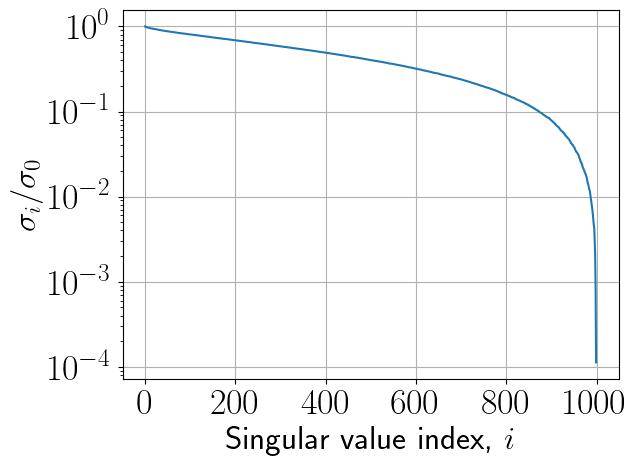

In [14]:
import numpy as np
import matplotlib.pyplot as plt
n = 1000
a = jax.random.normal(jax.random.PRNGKey(244747), (n, n))
u, s, v = jnp.linalg.svd(a)
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

## Applications of SVD

- SVD is extremely important in computational science and engineering.

- It has many names: Principal component analysis, Proper Orthogonal Decomposition, Empirical Orthogonal Functions

- Now we will consider compression of **dense** matrix and active subspaces method 

## Dense matrix compression

Dense matrices typically require $N^2$ elements to be stored. A rank-$r$ approximation can reduces this number to $\mathcal{O}(Nr)$

DeviceArray(-0.3372376, dtype=float32)

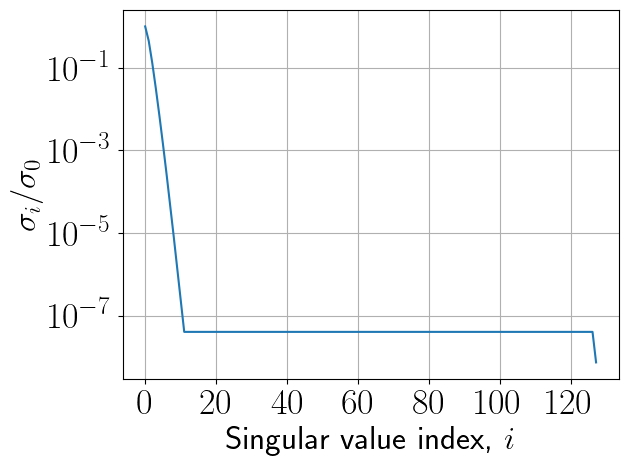

In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

n = 256
a = [[1.0/(i - j + 0.5) for i in range(n)] for j in range(n)]
a = np.array(a)
#u, s, v = np.linalg.svd(a)
u, s, v = jnp.linalg.svd(a[n//2:, :n//2])
plt.semilogy(s/s[0])
plt.ylabel(r"$\sigma_i / \sigma_0$", fontsize=24)
plt.xlabel(r"Singular value index, $i$", fontsize=24)
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
#s[0] - jnp.pi
#u, s, v = jnp.linalg.svd(a[:128:, :128])
#print(s[0]-jnp.pi)

## Compression of parameters in fully-connected neural networs

- One of the main building blocks of the modern deep neural networks is **fully-connected layer** a.k.a. **linear layer**
- This layer implements the action of a linear function to an input vector: $f(x) = Wx + b$, where $W$ is a trainable matrix and $b$ is a trainable bias vector
- Both $W$ and $b$ are updated during training of the network according to some optimization method, i.e. SGD, Adam, etc...
- However, the storing of the trained optimal parameters ($W$ and $b$) can be **prohibitive** if you want to port your trained network to the device, where memory is limited
- As a possible recipe, you can **compress** matrices $W_i$ from the $i$-th linear layer with the truncated SVD based on the singular values!
- What do you get after such apprioximation of $W$?
    - memory efficient storage
    - faster inference
    - moderate degradation of the accuracy in solving the target task, i.e. image classification
    

# Eigenvalues and eigenvectors

## What is an eigenvector?

- **Definition.** A vector $x \ne 0$ is called an **eigenvector** of a square matrix $A$ if there exists a number $\lambda$ such that  

$$ Ax = \lambda x. $$

- The number $\lambda$ is called an **eigenvalue**.  The name **eigenpair** is also used.

- Since $A - \lambda I$ should have a non-trivial kernel, eigenvalues are the roots of the characteristic polynomial

$$ \det (A - \lambda I) = 0.$$

## Eigendecomposition
If matrix $A$ of size $n\times n$ has $n$ eigenvectors $s_i$, $i=1,\dots,n$:

$$ As_i = \lambda_i s_i, $$

then this can be written as

$$ A S = S \Lambda, \quad\text{where}\quad S=(s_1,\dots,s_n), \quad \Lambda = \text{diag}(\lambda_1, \dots, \lambda_n), $$

or equivalently

$$ A = S\Lambda S^{-1}. $$

- This is called **eigendecomposition** of a matrix. Matrices that can be represented by their eigendecomposition are called **diagonalizable**.

## Why eigenvectors and eigenvalues are important?

- Eigenvectors are both important auxiliary tools and also play important role in applications.  

Can you give some examples?


## Applications of eigenvalues/eigenvectors

- **Communication theory:** theoretical limit on the amount of information transferred
- **Designing bridges** (mechanical engineering)
- **Designing** hifi-audio systems
- **Quantum chemistry:** all our microworld is governed by the **Schrodinger equation** which is an eigenvalue problem:

$$ H \psi = E \psi, $$

- Model order reduction of complex systems
- Graph analysis (PageRank, graph clustering)



## Eigenvalues are vibrational frequencies

A typical computation of eigenvectors / eigenvectors is for studying 

- Vibrational computations of mechanical structures
- Model order reduction of complex systems

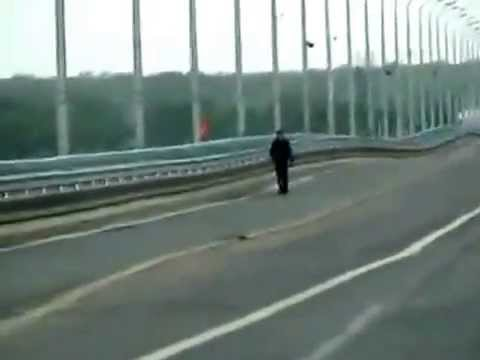

In [ ]:
from IPython.display import YouTubeVideo 
YouTubeVideo("VcCcMZo6J6w")

## Google PageRank
- One of the most famous eigenvectors computation is the **Google PageRank**. 
- It is not actively used by Google nowadays, but it was one of the main features in its early stages. The question is how do we rank webpages, which one is important, and which one is not. 
- All we know about the web is which page refers to which. PageRank is defined by a recursive definition. 
- Denote by $p_i$ the **importance** of the $i$-th page. 
- Then we define this importance as an average value of all importances of all pages that refer to the current page. It gives us a linear system  

$$ p_i = \sum_{j \in N(i)} \frac{p_j}{L(j)}, $$

where $L(j)$ is the number of outgoing links on the $j$-th page, $N(i)$ are all the neighbours of the $i$-th page. It can be rewritten as  

$$ p = G p, \quad G_{ij} = \frac{1}{L(j)} $$

or as an eigenvalue problem

$$
   Gp = 1 p,
$$

i.e. the eigenvalue $1$ is already known. Note that $G$ is **left stochastic**, i.e. its columns sum up to $1$. 
Check that any left stochastic matrix has maximum eigenvalue equal to $1$.

## Demo
- We can compute PageRank using some Python packages. 
- We will use ```networkx``` package for working with graphs that can be installed using  

```conda install networkx```

- Other packages to work with graphs in Python are [igraph](https://igraph.org/) and [graph-tool](https://graph-tool.skewed.de/)
- They can be useful in your projects

- We will use a simple example of [Zachary karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). 
- This data was manually collected in 1977, and is a classical social network dataset.

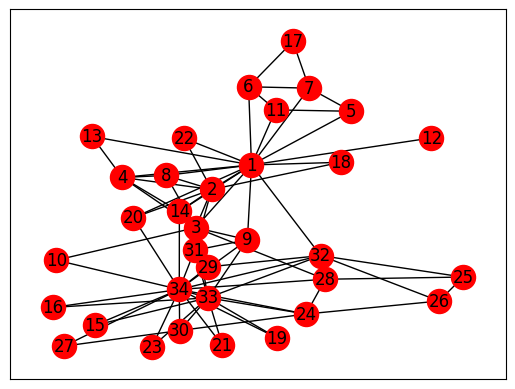

In [ ]:
import jax.numpy as jnp
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
#nx.write_gml(kn, 'karate2.gml')
nx.draw_networkx(kn, node_color="red") #Draw the graph

- Now we can actually compute the PageRank using the NetworkX built-in function. 
- We also plot the size of the nodes larger if its PageRank is larger.

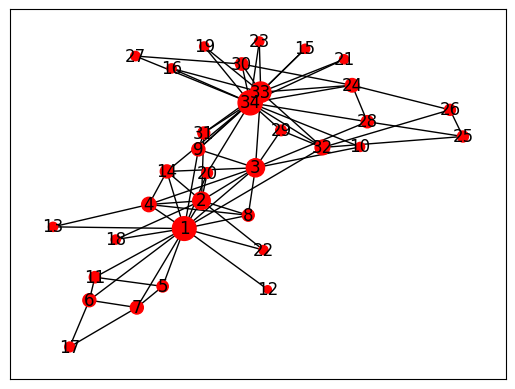

In [ ]:
pr = nx.algorithms.link_analysis.pagerank(kn)
pr_vector = list(pr.values())
pr_vector = jnp.array(pr_vector) * 3000
nx.draw_networkx(kn, node_size=pr_vector, node_color="red", labels=None)

## Computations of eigenvalues

- How to compute  eigenvalues and eigenvectors? 

There are two types of eigenproblems:

- full eigenproblem (all eigenvalues & eigenvectors are required)
- partial eigenvalues (minimal/maximal eigenvalues, eigenvalues within the specified region are required)

## Computation of the eigenvalues via characteristic equations
The eigenvalue problem has the form  

$$ Ax = \lambda x, $$

or

$$ (A - \lambda I) x = 0, $$

therefore matrix $A - \lambda I$ has non-trivial kernel and should be singular. 

That means, that the **determinant**  

$$ p(\lambda) = \det(A - \lambda I) = 0. $$

- The equation is called **characteristic equations** and is a polynomial of order $n$. 
- The $n$-degree polynomial has $n$ complex roots!

## Recall the determinant
The determinant of a square matrix $A$ is defined as 

$$\det A = \sum_{\sigma \in S_n} \mathrm{sgn}({\sigma})\prod^n_{i=1} a_{i, \sigma_i},$$

where 
- $S_n$ is the set of all **permutations** of the numbers $1, \ldots, n$
- $\mathrm{sgn}$ is the **signature** of the permutation ( $(-1)^p$, where $p$ is the number of transpositions to be made).

## Properties of determinant
Determinant has many nice properties:

_1._ $\det(AB) = \det(A) \det(B)$

_2._ If we have one row as a sum of two vectors, determinant is a sum of two determinants

_3._ "Minor expansion": we can expand  determinant through a selected row or column.

- If you do it via **minor expansion**, we get **exponential** complexity in $n$.

- Can we do $\mathcal{O}(n^3)$? 

## Eigenvalues and characteristic equation

- Now we go back to the eigenvalues.

- The characteristic equation can be used to compute the eigenvalues, which leads to **na&iuml;ve** algorithm:

$$p(\lambda) = \det(A - \lambda I)$$

1. Compute coefficients of the polynomial
2. Compute the roots

**Is this a good idea**?   

**Give your feedback**

We can do a short demo of this

## Power method

- We are often interested in the computation of the part of the spectrum, like the largest eigenvalues or smallest eigenvalues. 
- Also it is interesting to note that for the Hermitian matrices $(A = A^*)$ the eigenvalues are always real (prove it!).  
- A power method is the simplest method for the computation of **the largest eigenvalue in modulus**. 
- It is also our first example of the **iterative method** and **Krylov method**.

## Power method

- The eigenvalue problem

$$Ax = \lambda x, \quad \Vert x \Vert_2 = 1 \ \text{for stability}.$$ 

can be rewritten as a **fixed-point iteration**.
- This iteration is called **power method** and finds the largest in modulus eigenvalue of $A$.

Power method has the form

$$ x_{k+1} = A x_k, \quad x_{k+1} := \frac{x_{k+1}}{\Vert x_{k+1} \Vert_2}$$

and 

$$ x_{k+1}\to v_1,$$ 

where $Av_1 = \lambda_1 v_1$ and $\lambda_1$ is the largest eigenvalue and $v_1$ is the corresponding eigenvector.

- On the $(k+1)$-th iteration approximation to $\lambda_1$ can be found as

$$ \lambda^{(k+1)} = (Ax_{k+1}, x_{k+1}), $$

- Note that $\lambda^{(k+1)}$ is not required for the $(k+2)$-th iteration, but might be useful to measure error on each iteration: $\|Ax_{k+1} - \lambda^{(k+1)}x_{k+1}\|$. 

- The convergence is geometric, but the convergence ratio is $q^k$, where $q = \left|\frac{\lambda_{2}}{\lambda_{1}}\right| < 1$, for $\lambda_1>\lambda_2\geq\dots\geq \lambda_n$ and $k$ is the number of iteration. 
- It means, the convergence can be artitrary small. To prove it, it is sufficient to consider a $2 \times 2$ diagonal matrix.

## Things to remember about the power method
- Power method gives estimate of the largest eigenvalue in modulus or spectral radius of the given matrix
- One step requires one matrix-by-vector product. If the matrix allows for an $\mathcal{O}(n)$ matvec (for example, it is sparse), 
  then power method is tractable for larger $n$.
- Convergence can be slow
- If only a rough estimate is needed, only a few iterations are sufficient
- The solution vector is in the **Krylov subspace** $\{x_0, Ax_0,\dots,A^{k}x_0\}$ and has the form $\mu A^k x_0$, where $\mu$ is the normalization constant. 


#  Matrix decomposition: the Schur form
There is one class of matrices when eigenvalues can be found easily: **triangular matrices**

$$
  A = \begin{pmatrix}
   \lambda_1 & * & * \\
   0 & \lambda_2 & * \\
   0 & 0 & \lambda_3 \\
  \end{pmatrix}.
$$

The eigenvalues of $A$ are $\lambda_1, \lambda_2, \lambda_3$. Why? 

Because the determinant is  

$$
   \det(A - \lambda I) = (\lambda - \lambda_1) (\lambda - \lambda_2) (\lambda - \lambda_3).
$$

- Thus, computing the eigenvalues of triangular matrices is easy. Now, the unitary matrices come to help. 
- Let $U$ be a unitary matrix, i.e. $U^* U = I$.  Then 

$$
   \det(A - \lambda I) = \det(U (U^* A U - \lambda I) U^*) = \det(UU^*) \det(U^* A U - \lambda I) = \det(U^* A U - \lambda I),
$$

where we have used the famous multiplicativity property of the determinant, $\det(AB) = \det(A) \det(B)$. 
- It means, that the matrices $U^* A U$ and $A$ have the same characteristic polynomials, and the same eigenvalues. 

- If we manage to make $U^* A U = T$ where $T$ is **upper triangular**, then we are done.  

- Multplying from the left and the right by $U$ and $U^*$ respectively, we get the desired decomposition:  

$$ A = U T U^*. $$

This is the celebrated **Schur decomposition**. 
- Recall that unitary matrices imply stability, thus the eigenvalues are computed very accurately. The Schur decomposition shows why we need matrix decompositions: it represents a matrix into a product of three matrices with a convenient structure.  

## Schur theorem

**Theorem:** Every $A \in \mathbb{C}^{n \times n}$ matrix can be represented in the Schur form $A = UTU^*$, where $U$ is unitary and $T$ is upper triangular.  

**Sketch of the proof**.
1. Every matrix has at least $1$ non-zero eigenvector (take a root of characteristic polynomial, $(A-\lambda I)$ is singular, has    non-trivial nullspace). Let 

$$Av_1 = \lambda_1 v_1, \quad \Vert v_1 \Vert_2 = 1$$

2. Let $U_1 = [v_1,v_2,\dots,v_n]$, where $v_2,\dots, v_n$ are any vectors othogonal to $v_1$. Then 
  
$$ U^*_1 A U_1 = \begin{pmatrix} \lambda_1 & *  \\ 0 & A_2  \end{pmatrix}, $$
  
where $A_2$ is an $(n-1) \times (n-1)$ matrix. This is called **block triangular form**. We can now work with $A_2$ only and so on.  
  
**Note**: Since we need eigenvectors in this proof, this proof is not a practical algorithm.

## Application of the Schur theorem

- Important application of the Schur theorem:  **normal matrices**.  

- **Definition.** Matrix $A$ is called **normal matrix**, if  

$$ AA^* = A^* A. $$

**Q:** Examples of normal matrices?

Examples: Hermitian matrices, unitary matrices.  

## Normal matrices

**Theorem**: $A$ is a **normal matrix**, iff $A = U \Lambda U^*$, where $U$ is unitary and $\Lambda$ is diagonal. 

**Sketch of the proof:** 
- One way is straightforward (if the decomposition holds, the matrix is normal).  
- The other is more complicated. Consider the Schur form of the matrix $A$. Then $AA^* = A^*A$ means $TT^* = T^* T$.  
- By looking at the elements we immediately see, that the only upper triangular matrix $T$ that satisfies $TT^* = T^* T$ is a diagonal matrix!

#### Important consequence

Therefore, every normal matrix is **unitary diagonalizable**, which means that it can be diagonalized by unitary matrix $U$. 

In other words every normal matrix has orthogonal basis of eigenvectors.